## Assignment: $k$ Means Clustering

## **Do two questions.**

`! git clone https://www.github.com/DS3001/kmc`

In [2]:
! git clone https://www.github.com/DS3001/kmc

Cloning into 'kmc'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 25 (delta 4), reused 3 (delta 3), pack-reused 18
Receiving objects: 100% (25/25), 5.04 MiB | 15.60 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Q1.** This question is a case study for $k$ means clustering.

1. Load the `airbnb_hw.csv` data. Clean `Price` along with `Beds`, `Number of Reviews`, and `Review Scores Rating`.
2. Maxmin normalize the data and remove any `nan`'s (`KMeans` from `sklearn` doesn't accept `nan` input).
3. Use `sklearn`'s `KMeans` module to cluster the data by `Beds`, `Number of Reviews`, and `Review Scores Rating` for `k=6`.
4. Use `seaborn`'s `.pairplot()` to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.
5. Use `.groupby` and `.describe` to compute the average price for each cluster. Which clusters have the highest rental prices?
6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

In [5]:
df = pd.read_csv('/content/kmc/data/airbnb_hw.csv')
df.head()
df.dtypes
#df.shape
df.describe() #lots of columns
x = df.loc[:, ['Price','Beds', 'Number Of Reviews', 'Review Scores Rating']] # look at just what we want
x.describe()
#missing beds and ratings so we need to clean those so they = 30478
#need to cast price to int + remove commas


,Beds,Number Of Reviews,Review Scores Rating
count,30393.000000,30478.000000,22155.000000
mean,1.530089,12.018735,91.993230
std,1.015359,21.980703,8.850373
min,0.000000,0.000000,20.000000
25%,1.000000,0.000000,89.000000
50%,1.000000,3.000000,94.000000
75%,2.000000,13.000000,100.000000
max,16.000000,257.000000,100.000000


In [6]:
df.dtypes

Host Id                         int64
Host Since                     object
Name                           object
Neighbourhood                  object
Property Type                  object
Review Scores Rating (bin)    float64
Room Type                      object
Zipcode                       float64
Beds                          float64
Number of Records               int64
Number Of Reviews               int64
Price                          object
Review Scores Rating          float64
dtype: object

In [31]:

x['Price'] = df['Price'].str.replace(',', '')
x['Price']=pd.to_numeric(x['Price'],errors ='coerce')
x.describe()



,Beds,Number Of Reviews,Review Scores Rating,Price
count,30478.000000,30478.000000,22155.000000,30478.000000
mean,1.528611,12.018735,91.993230,163.589737
std,1.014327,21.980703,8.850373,197.785454
min,0.000000,0.000000,20.000000,10.000000
25%,1.000000,0.000000,89.000000,80.000000
50%,1.000000,3.000000,94.000000,125.000000
75%,2.000000,13.000000,100.000000,195.000000
max,16.000000,257.000000,100.000000,10000.000000


In [46]:
# clean beds
x['Beds'] = x['Beds'].fillna(1) #fill emptys with 1 so they become 30478
x.describe()

,Beds,Number Of Reviews,Review Scores Rating,Price
count,30478.000000,30478.000000,22155.000000,30478.000000
mean,1.528611,12.018735,91.993230,163.589737
std,1.014327,21.980703,8.850373,197.785454
min,0.000000,0.000000,20.000000,10.000000
25%,1.000000,0.000000,89.000000,80.000000
50%,1.000000,3.000000,94.000000,125.000000
75%,2.000000,13.000000,100.000000,195.000000
max,16.000000,257.000000,100.000000,10000.000000


In [48]:
#need to do the same with review scores -> need to see how many reviews are missing vs how many don't have values

pd.crosstab((df['Review Scores Rating'].isnull()), df['Number Of Reviews']>0)


Number Of Reviews,False,True
Review Scores Rating,,
False,0,22155
True,7814,509


Shows us that there are 22155 that have reviews with no rating, 7814 with no review but a rating, and 509 with no review and no rating. We could drop these so that the data and clusters only reflects the reviews we actually have ratings for or we could also impute the average value.

In [52]:
x=x.dropna()
x.describe()

,Beds,Number Of Reviews,Review Scores Rating,Price
count,22155.000000,22155.000000,22155.000000,22155.000000
mean,1.556985,16.505439,91.993230,154.787633
std,1.043273,24.308241,8.850373,148.836621
min,0.000000,1.000000,20.000000,10.000000
25%,1.000000,2.000000,89.000000,85.000000
50%,1.000000,7.000000,94.000000,125.000000
75%,2.000000,20.000000,100.000000,190.000000
max,16.000000,257.000000,100.000000,10000.000000


2. Maxmin normalize and remove nans


In [53]:
def maxmin(z): #define maxmin function
  u = (z-min(z))/(max(z)-min(z))
  return(u)
no_price = x.drop('Price', axis=1)
no_price.apply(maxmin)
no_price.describe()

,Beds,Number Of Reviews,Review Scores Rating
count,22155.000000,22155.000000,22155.000000
mean,1.556985,16.505439,91.993230
std,1.043273,24.308241,8.850373
min,0.000000,1.000000,20.000000
25%,1.000000,2.000000,89.000000
50%,1.000000,7.000000,94.000000
75%,2.000000,20.000000,100.000000
max,16.000000,257.000000,100.000000


3. Use sklearn's KMeans module to cluster the data by Beds, Number of Reviews, and Review Scores Rating for k=6.

4. Use seaborn's .pairplot() to make a grid of scatterplots that show how the clustering is carried out in multiple dimensions.

In [55]:
from sklearn.cluster import KMeans # Import kmc
#initial_centroids = np.random.randint(low=1,high=24,size=3) # Determine initial centroids
#model = KMeans(n_clusters=1, max_iter=300, init =10,  random_state=0) # Pass centroids and options into the model
#model = model.fit(x) # Initialize a kmc model
#df['g_hat'] = model.predict(x) # Predict values

model = KMeans(n_clusters=6, max_iter=300, n_init = 10, random_state=0) # Create a model for
model = model.fit(no_price) # Fit the emodel
no_price['cluster'] = model.labels_
no_price.describe()

,Beds,Number Of Reviews,Review Scores Rating,cluster
count,22155.000000,22155.000000,22155.000000,22155.000000
mean,1.556985,16.505439,91.993230,2.544708
std,1.043273,24.308241,8.850373,0.964160
min,0.000000,1.000000,20.000000,0.000000
25%,1.000000,2.000000,89.000000,2.000000
50%,1.000000,7.000000,94.000000,3.000000
75%,2.000000,20.000000,100.000000,3.000000
max,16.000000,257.000000,100.000000,5.000000


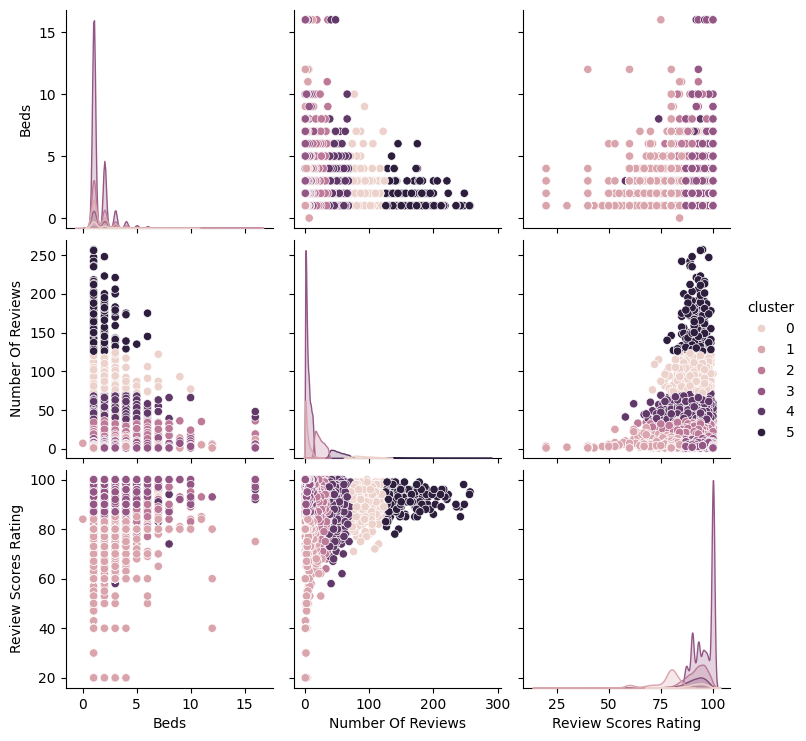

In [63]:
sns.pairplot(no_price, hue='cluster')

START
 HERE
5. Use .groupby and .describe to compute the average price for each cluster. Which clusters have the highest rental prices?

6. Use a scree plot to pick the number of clusters and repeat steps 4 and 5.

In [66]:
no_price.loc[:,['Beds', 'cluster']].groupby('cluster').describe()

Beds                                              
           count      mean       std  min  25%  50%  75%   max
cluster                                                       
0          738.0  1.589431  1.017218  1.0  1.0  1.0  2.0  10.0
1         2921.0  1.652859  1.188990  0.0  1.0  1.0  2.0  16.0
2         4273.0  1.632811  1.103586  1.0  1.0  1.0  2.0  16.0
3        12154.0  1.487412  0.965656  1.0  1.0  1.0  2.0  16.0
4         1896.0  1.669304  1.123896  1.0  1.0  1.0  2.0  16.0
5          173.0  1.583815  0.958544  1.0  1.0  1.0  2.0   6.0

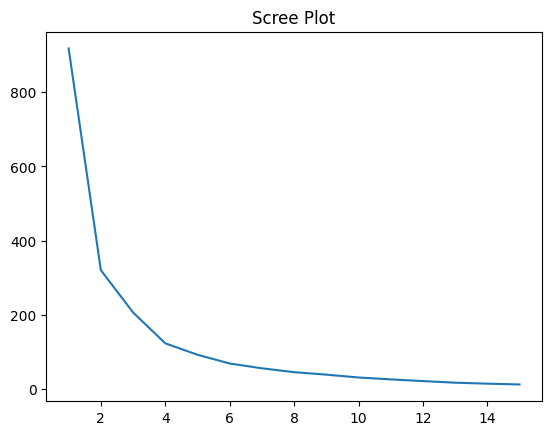

In [109]:
#scree plot
X = no_price.loc[ : , ['Beds','cluster'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

k_bar = 15
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot') # Create scree plot

**Q2.** This is a question about $k$ means clustering. We want to investigate how adjusting the "noisiness" of the data impacts the quality of the algorithm and the difficulty of picking $k$.

1. Run the code below, which creates four datasets: `df0_125`, `df0_25`, `df0_5`, `df1_0`, and `df2_0`. Each data set is created by increasing the amount of `noise` (standard deviation) around the cluster centers, from `0.125` to `0.25` to `0.5` to `1.0` to `2.0`.

```
import numpy as np
import pandas as pd

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,1,N),np.random.normal(1,1,N)])
    X2 = np.array([np.random.normal(3,1,N),np.random.normal(2,1,N)])
    X3 = np.array([np.random.normal(5,1,N),np.random.normal(3,1,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)
```

2. Make scatterplots of the $(X1,X2)$ points by group for each of the datasets. As the `noise` goes up from 0.125 to 2.0, what happens to the visual distinctness of the clusters?
3. Create a scree plot for each of the datasets. Describe how the level of `noise` affects the scree plot (particularly the presence of a clear "elbow") and your ability to definitively select a $k$.
4. Explain the intuition of the elbow, using this numerical simulation as an example.

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans # Import kmc
import matplotlib.pyplot as plt

def createData(noise,N=50):
    np.random.seed(100) # Set the seed for replicability
    # Generate (x1,x2,g) triples:
    X1 = np.array([np.random.normal(1,noise,N),np.random.normal(1,noise,N)])
    X2 = np.array([np.random.normal(3,noise,N),np.random.normal(2,noise,N)])
    X3 = np.array([np.random.normal(5,noise,N),np.random.normal(3,noise,N)])
    # Concatenate into one data frame
    gdf1 = pd.DataFrame({'x1':X1[0,:],'x2':X1[1,:],'group':'a'})
    gdf2 = pd.DataFrame({'x1':X2[0,:],'x2':X2[1,:],'group':'b'})
    gdf3 = pd.DataFrame({'x1':X3[0,:],'x2':X3[1,:],'group':'c'})
    df = pd.concat([gdf1,gdf2,gdf3],axis=0)
    return df

df0_125 = createData(0.125)
df0_25 = createData(0.25)
df0_5 = createData(0.5)
df1_0 = createData(1.0)
df2_0 = createData(2.0)

<Axes: xlabel='x1', ylabel='x2'>

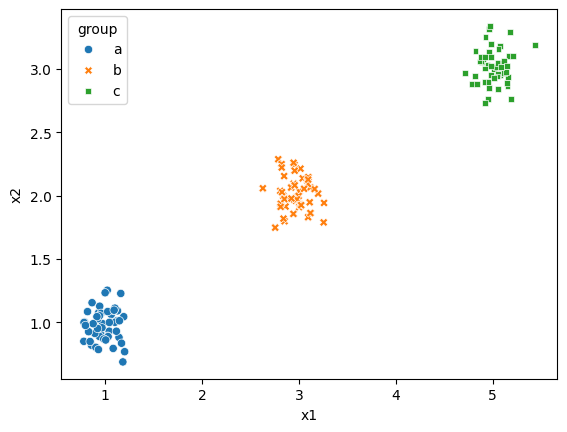

In [90]:
sns.scatterplot(data = df0_125, x='x1', y ='x2', hue = 'group', style ='group')


<Axes: xlabel='x1', ylabel='x2'>

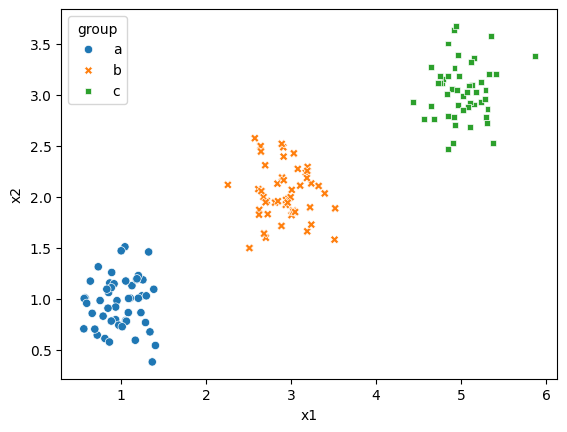

In [86]:
sns.scatterplot(data = df0_25, x='x1', y ='x2', hue = 'group', style ='group')

<Axes: xlabel='x1', ylabel='x2'>

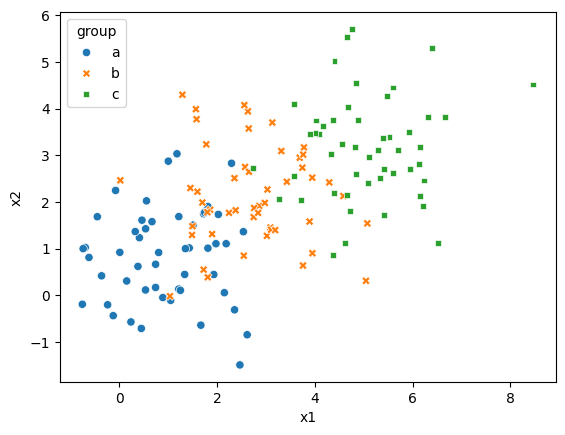

In [87]:
sns.scatterplot(data = df1_0, x='x1', y ='x2', hue = 'group', style ='group')

<Axes: xlabel='x1', ylabel='x2'>

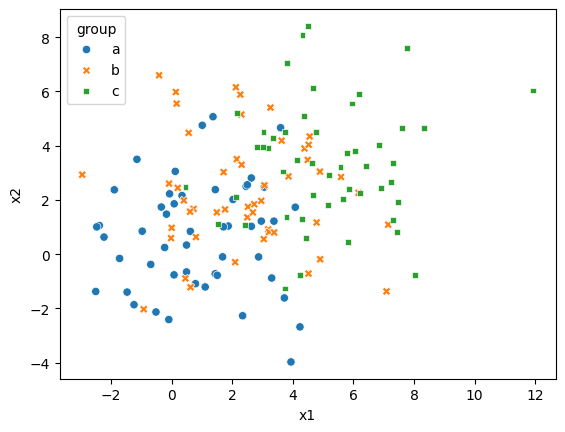

In [88]:
sns.scatterplot(data = df2_0, x='x1', y ='x2', hue = 'group', style ='group')

As noise increases the clusters become less defined and combine into one giant mass where you can't tell what cluster is which

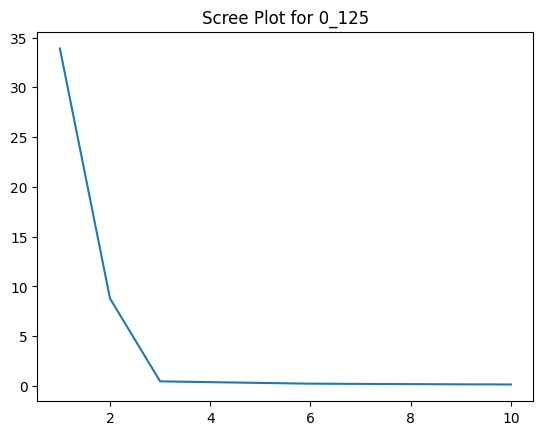

In [103]:
# Create a scree plot to plot SSE(k) against number of k to see how adding a cluster changes fit:
# Preprocess the data:
X = df0_125.loc[ : , ['x1','x2'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

k_bar = 10
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot for 0_125') # Create scree plot

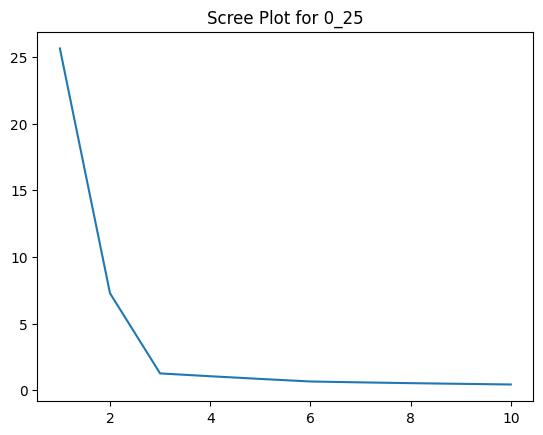

In [102]:
X = df0_25.loc[ : , ['x1','x2'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

k_bar = 10
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot for 0_25') # Create scree plot

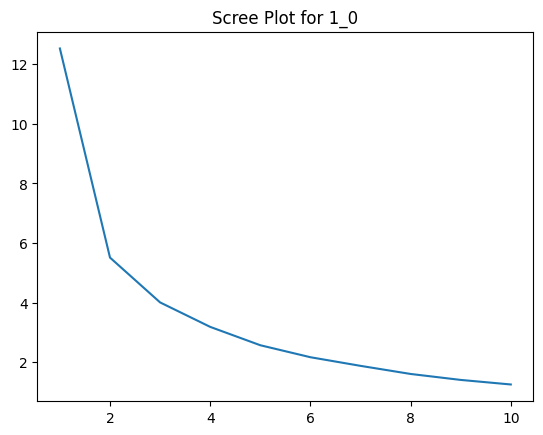

In [101]:
X = df1_0.loc[ : , ['x1','x2'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

k_bar = 10
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot for 1_0') # Create scree plot

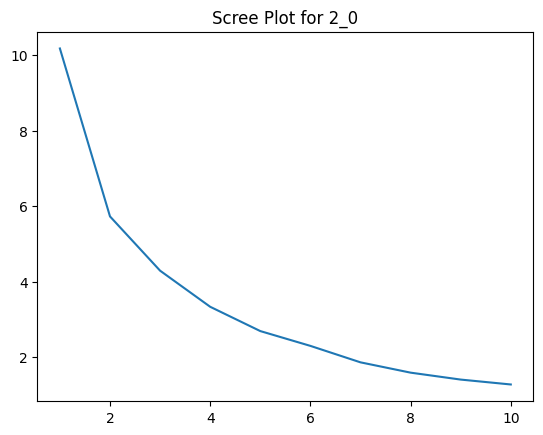

In [100]:
# Preprocess the data:
X = df2_0.loc[ : , ['x1','x2'] ] # Select data to cluster
X = X.apply(maxmin) # Normalize the data

# Create a scree plot:
k_bar = 10
k_grid = np.arange(1,k_bar+1) # The range of k's to consider
SSE = np.zeros(k_bar) # We'll store the training error here
for k in range(k_bar): # For indices from 0 to k_bar-1
    model = KMeans(n_clusters=k+1, max_iter=300, n_init = 10, random_state=0) # Create a model for k
    model = model.fit(X) # Fit the emodel
    SSE[k] = model.inertia_ # Record the sum of squared error for k in the SSE vector

scree_plot = sns.lineplot(x=k_grid, y=SSE).set_title('Scree Plot for 2_0') # Create scree plot


The elbow is where the reduction in  𝑆𝑆𝐸  of going from  𝑘−1  to  𝑘  drops significantly compared from  𝑘  to  𝑘+1.
This means the marginal benefit of an additional cluster is small, and increasing  𝑘  further is probably not really improving the fit. If there are distinct clusters then you can probably add another k. In other words, we want to strike a balance between reducing error and having too many clusters. The scatter plot shows us what happens when the clusters spread out too much because of "noise" and you can't really differentiate them. However, the scree plots showed us more clearly where the elbow point could be. Here, it appears to be 2.



**Q3.** We looked at computer vision with $k$NN in a previous question. Can $k$ means clustering correctly group digits, even if we don't know which symbols are which?

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5):
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use $k$ means clustering on the reshaped `X_test` data with `k=10`.  
5. Cross tabulate the cluster assignments with the true labels for the test set values. How good is the correspondence? What proportion of digits are clustered correctly? Which digits are the hardest to distinguish from one another? Can $k$MC recover the latent digits 0 to 9, without even knowing what those digits were?
6. If you use a scree plot to determine the number of clusters $k$, does it pick 10 (the true number of digits), or not? If it fails to pick $k=10$, which digits does it tend to combine into the same classification?